In [1]:
import os.path

from absl import app
from absl import flags
from absl import logging

import numpy as np
import tensorflow as tf
import uncertainty_baselines as ub
import uncertainty_metrics as um

from resnet20_multihead import create_model as resnet20_multihead
from resnet20_multihead import train_model as resnet20_multihead_train
from resnet20_multihead import load_model as resnet20_multihead_load
from resnet20_multihead import calibrate_model_isotonic,calibrate_model_temp

from func import load_datasets_basic, load_datasets_corrupted, add_dataset_flags
from func import AttrDict

from metrics import rel_diag,ece
from metrics import comp_metrics, quartiles


<h2>training</h2>

In [18]:
FLAGS = AttrDict({'seed':1337,
                  'output_dir':'0dir1_sin',
                  'optimizer': 'adam',
                  'learning_rate':0.01,
                  'weight_decay':None,
                  'model_file':'dir0/model.ckpt-50',
                  'dataset':'cifar10',
                  'certainty_variant':'partial',
                  'activation':'sin',
                  'batch_size':128,
                  'eval_batch_size':100,
                  'validation_percent':0.1,
                  'eval_frequency':100,
                  'num_bins':15,
                  'epochs':60
                 })

In [19]:
logging.info('Multihead CIFAR-10 ResNet-20 train')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(FLAGS.output_dir,'logs'))

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

optimizer = ub.optimizers.get(optimizer_name=FLAGS.optimizer,
                              learning_rate_schedule='constant',
                              learning_rate=FLAGS.learning_rate,
                              weight_decay=FLAGS.weight_decay)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                           l2_weight=None,
                           certainty_variant=FLAGS.certainty_variant,
                           activation_type=FLAGS.activation)

   



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [20]:
resnet20_multihead_train(model=model,
                         train_dataset=train_dataset,
                         val_dataset = val_dataset,
                         optimizer = optimizer,
                         FLAGS = FLAGS,
                         tensorboard_callback = tensorboard_callback
                        )

Epoch 1/60
  1/351 [..............................] - ETA: 0s - loss: 7.5149 - dense_3_loss: 7.5149 - tf_op_layer_stack_3_ece: 0.1158 - dense_3_sparse_categorical_accuracy: 0.1172 - tf_op_layer_Neg_3_sparse_categorical_accuracy: 0.1172 - tf_op_layer_Sigmoid_3_ece: 0.6105WARNING:tensorflow:From /home/jgrela/miniconda3/envs/uncert-5/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/351 [..............................] - ETA: 1:13 - loss: 6.5357 - dense_3_loss: 6.5357 - tf_op_layer_stack_3_ece: 0.1001 - dense_3_sparse_categorical_accuracy: 0.1055 - tf_op_layer_Neg_3_sparse_categorical_accuracy: 0.1055 - tf_op_layer_Sigmoid_3_ece: 0.5410WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0243s vs `on_train_batch_end` time: 0.3910s). Check your callbacks.


204/351 [================>.............] - ETA: 3s - loss: 2.7645 - dense_3_loss: 2.7645 - tf_op_layer_stack_3_ece: 0.1833 - dense_3_sparse_categorical_accuracy: 0.3163 - tf_op_layer_Neg_3_sparse_categorical_accuracy: 0.3163 - tf_op_layer_Sigmoid_3_ece: 0.0354

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jgrela/miniconda3/envs/uncert-5/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-3830f9bf2314>", line 6, in <module>
    tensorboard_callback = tensorboard_callback
  File "/home/jgrela/uncertainty-baselines/experimental/multihead/resnet20_multihead.py", line 215, in train_model
    shuffle=False)
  File "/home/jgrela/miniconda3/envs/uncert-5/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/home/jgrela/miniconda3/envs/uncert-5/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1098, in fit
    tmp_logs = train_function(iterator)
  File "/home/jgrela/miniconda3/envs/uncert-5/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, 

TypeError: object of type 'NoneType' has no len()

<h2>calibration + reliability diagrams</h2>

In [2]:
FLAGS = AttrDict({'seed':1337,
                  'output_dir':'dir1_relu',
                  'optimizer': 'adam',
                  'learning_rate':0.01,
                  'weight_decay':None,
                  'model_file':'dir1_relu/model.ckpt-60',
                  'dataset':'cifar10',
                  'certainty_variant':'partial',
                  'activation':'relu',
                  'batch_size':128,
                  'eval_batch_size':100,
                  'validation_percent':0.1,
                  'eval_frequency':100,
                  'num_bins':15,
                  'epochs':60
                 })

In [3]:
logging.info('Multihead CIFAR-10 ResNet-20 calibrate')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                           l2_weight=None,
                           certainty_variant=FLAGS.certainty_variant,
                           activation_type=FLAGS.activation)

resnet20_multihead_load(model,FLAGS)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
cal_model_iso, _ = calibrate_model_isotonic(model,
                                               val_dataset,
                                               FLAGS=FLAGS,
                                               prob_output='certs',
                                              )

In [5]:
cal_model_temp, _ = calibrate_model_temp(model,
                                               val_dataset,
                                               FLAGS=FLAGS,
                                               logit_output='logits_from_certs',
                                               epochs=20,
                                              )

0 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49333718>, 3.1990714]
1 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49505633>, 3.2253883]
2 [<tf.Tensor: shape=(), dtype=float32, numpy=0.4949463>, 3.2235265]
3 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49489856>, 3.2227352]
4 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49487388>, 3.2223172]
5 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49485627>, 3.2220201]
6 [<tf.Tensor: shape=(), dtype=float32, numpy=0.4948434>, 3.2218025]
7 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49483353>, 3.221636]
8 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49482575>, 3.221505]
9 [<tf.Tensor: shape=(), dtype=float32, numpy=0.4948195>, 3.2213995]
10 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49481437>, 3.2213128]
11 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49481001>, 3.22124]
12 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49480632>, 3.2211788]
13 [<tf.Tensor: shape=(), dtype=float32, numpy=0.49480328>, 3.221127]
14 [<tf.Tensor: shape=()

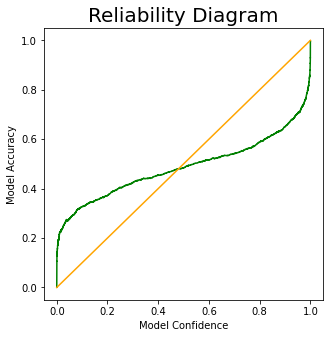

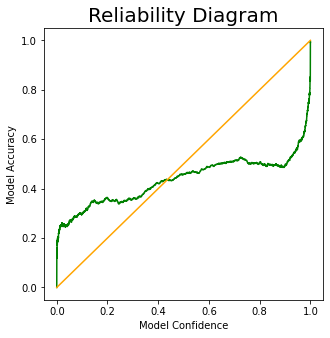

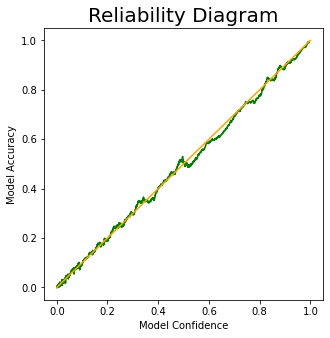

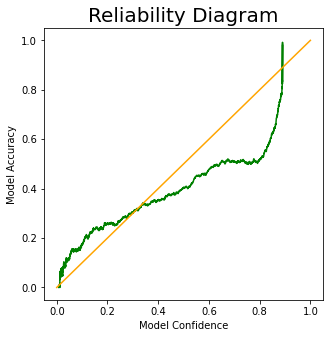

In [6]:
rel_diag(model,train_dataset,FLAGS,prob_output='certs')
rel_diag(model,val_dataset,FLAGS,prob_output='certs')
rel_diag(cal_model_iso,val_dataset,FLAGS,prob_output='certs_cal')
rel_diag(cal_model_temp,val_dataset,FLAGS,prob_output='logits_from_certs_cal')

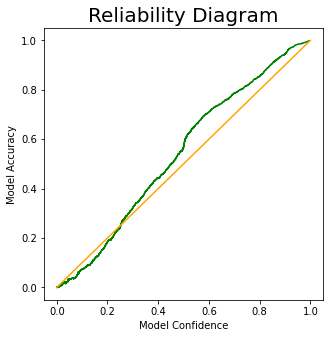

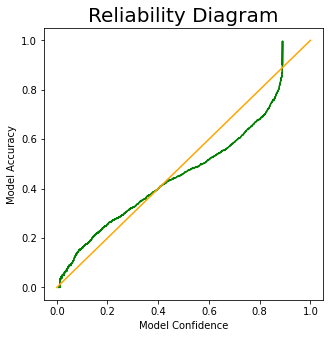

In [7]:
rel_diag(cal_model_iso,train_dataset,FLAGS,prob_output='certs_cal')
rel_diag(cal_model_temp,train_dataset,FLAGS,prob_output='logits_from_certs_cal')

<h2>single ECE</h2>

In [8]:
FLAGS = AttrDict({'seed':1337,
                  'output_dir':'dir1_relu',
                  'optimizer': 'adam',
                  'learning_rate':0.01,
                  'weight_decay':None,
                  'model_file':'dir1_relu/model.ckpt-60',
                  'dataset':'cifar10',
                  'certainty_variant':'partial',
                  'activation':'relu',
                  'batch_size':128,
                  'eval_batch_size':100,
                  'validation_percent':0.1,
                  'eval_frequency':100,
                  'num_bins':15,
                  'epochs':60
                 })

In [9]:
logging.info('Multihead CIFAR-10 ResNet-20 ECE')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                           l2_weight=None,
                           certainty_variant=FLAGS.certainty_variant,
                           activation_type=FLAGS.activation)

resnet20_multihead_load(model,FLAGS)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [10]:
cal_model_iso, _ = calibrate_model_isotonic(model,
                                               val_dataset,
                                               FLAGS=FLAGS,
                                               prob_output='certs', #or 'probs'
                                              )

In [11]:
ece(cal_model_iso,val_dataset,FLAGS,prob_output='certs_cal')

0.013388589024543762

<h2>batch ECE for corrupted CIFAR10</h2>

In [12]:
FLAGS = AttrDict({'seed':1337,
                  'output_dir':'dir1_relu',
                  'optimizer': 'adam',
                  'learning_rate':0.01,
                  'weight_decay':None,
                  'model_file':'dir1_relu/model.ckpt-60',
                  'dataset':'cifar10',
                  'certainty_variant':'partial',
                  'activation':'relu',
                  'batch_size':128,
                  'eval_batch_size':100,
                  'validation_percent':0.1,
                  'eval_frequency':100,
                  'num_bins':15,
                  'epochs':60
                 })

In [13]:
logging.info('Multihead CIFAR-10 ResNet-20 batch ECE')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
_, test_datasets_corrupt = load_datasets_corrupted(FLAGS)
logging.info(f'Loaded corrupted test_datasets...{len(test_datasets_corrupt)-1}')
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                           l2_weight=None,
                           certainty_variant=FLAGS.certainty_variant,
                           activation_type=FLAGS.activation)

resnet20_multihead_load(model,FLAGS)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [14]:
metrics = {'ece':um.ExpectedCalibrationError(num_bins=FLAGS.num_bins, name='ece')}

results, quartiles = comp_metrics(model=model,
                                   datasets=test_datasets_corrupt,
                                   metrics=metrics,
                                   FLAGS=FLAGS,
                                   prob_output='certs',
                                   return_quartiles=True)

In [16]:
quartiles

(0.17085923627018929, 0.21984294801950455, 0.2641681209206581)